In [2]:
import pandas as pd
import numpy as np

file_path = "/content/drive/MyDrive/Pedestrian_Crossing.csv"

df = pd.read_csv(file_path)

print(df.head())
print(df.info())

        ITEM_TYPE_NAME CROSSING_TYPE_NAME  \
0  PEDESTRIAN CROSSING       UNCONTROLLED   
1  PEDESTRIAN CROSSING  SIGNAL CONTROLLED   
2  PEDESTRIAN CROSSING  SIGNAL CONTROLLED   
3  PEDESTRIAN CROSSING  SIGNAL CONTROLLED   
4  PEDESTRIAN CROSSING  SIGNAL CONTROLLED   

                                        SECTION_NAME   EASTING  NORTHING  \
0  7020A0042_08 MAIN ST13: SECTION BOUNDARY AT PO...  297773.0  403872.0   
1  7035U0103_01 BALLYREGAN RD1: UPPER NEWTOWNARDS...  341940.0  374027.0   
2  7035U0129_01 GLENCREGAGH RD1: UPPER KNOCKBREDA...  335482.0  370425.0   
3  7050A0005_03 VICTORIA RD3: DUNCASTLE RD TO CLA...  241115.0  412573.0   
4  7050A2002_01 CLOONEY RD3: LONGFIELD RBT TO DUN...  256696.0  420967.0   

            START_DATE  
0  27/05/2005 00:00:00  
1  16/06/2005 00:00:00  
2  01/08/2007 00:00:00  
3  19/02/2013 00:00:00  
4  19/02/2013 00:00:00  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1558 entries, 0 to 1557
Data columns (total 6 columns):
 #   Column     

In [12]:
# Shows how many NaNs each column has
df.isnull().sum()

ITEM_TYPE_NAME        0
CROSSING_TYPE_NAME    4
SECTION_NAME          0
EASTING               0
NORTHING              0
START_DATE            0
dtype: int64

In [13]:
df.dropna(inplace=True)

In [11]:
print(f"The dataset has {len(df)} rows.")

The dataset has 1558 rows.


In [3]:
# Remove duplicated rows and keep the first occurrence
df = df.drop_duplicates()

# If you want to reset the index after removing duplicates
df = df.reset_index(drop=True)

print(f"Dataset now has {len(df)} rows after removing duplicates.")

Dataset now has 1542 rows after removing duplicates.


/tmp/ipython-input-2051148781.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


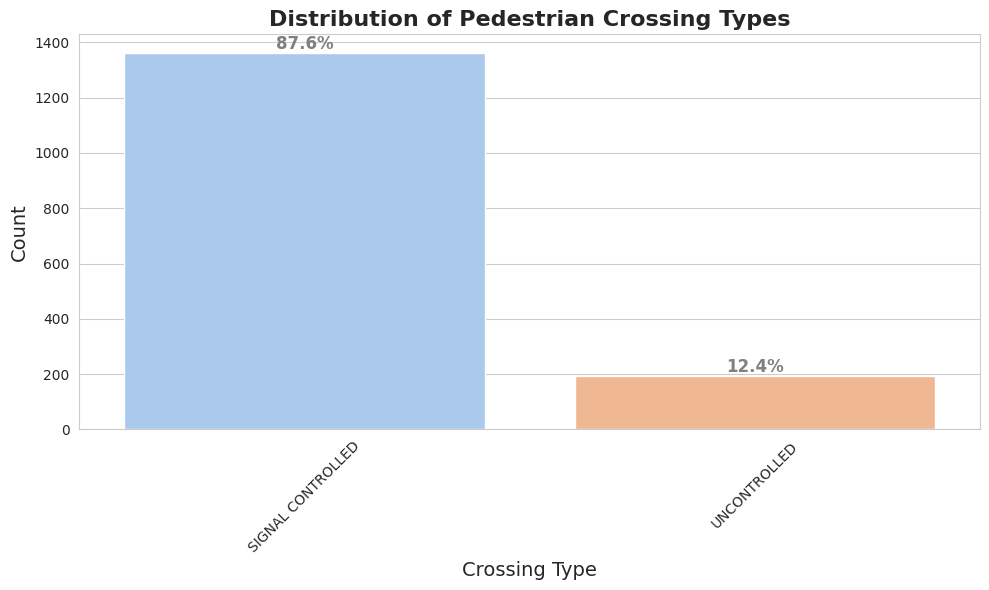

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Replace "?" with NaN
df["CROSSING_TYPE_NAME"] = df["CROSSING_TYPE_NAME"].replace("?", np.nan)

# Drop NaNs for plotting
plot_data = df["CROSSING_TYPE_NAME"].dropna()

# Set style
sns.set_style("whitegrid")
plt.figure(figsize=(10,6))

# Countplot with vibrant palette
ax = sns.countplot(
    x=plot_data,
    palette="pastel",
    order=plot_data.value_counts().index
)

# Add percentages on top of bars
total = len(plot_data)
for p in ax.patches:
    height = p.get_height()
    percentage = f'{100 * height / total:.1f}%'
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='gray')

# Titles and labels
plt.title("Distribution of Pedestrian Crossing Types", fontsize=16, fontweight='bold')
plt.xlabel("Crossing Type", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [5]:
import pandas as pd
import folium
from pyproj import Transformer

# Load your data
df = pd.read_csv("/content/drive/MyDrive/Pedestrian_Crossing.csv")  # Replace with your file

# Create a transformer: Irish Grid (EPSG:29902) → WGS84 (EPSG:4326)
# If your dataset uses the newer ITM coordinates, change to EPSG:29903
transformer = Transformer.from_crs("EPSG:29902", "EPSG:4326", always_xy=True)

# Convert EASTING/NORTHING to lat/lon
df["LON"], df["LAT"] = transformer.transform(df["EASTING"].values, df["NORTHING"].values)

# Create map centered over Northern Ireland
m = folium.Map(location=[54.6, -6.7], zoom_start=8)

# Add markers
for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row["LAT"], row["LON"]],
        radius=3,
        popup=f"{row['ITEM_TYPE_NAME']} - {row['CROSSING_TYPE_NAME']}",
        color="blue",
        fill=True,
        fill_opacity=0.6
    ).add_to(m)

# Save and display
m.save("/content/drive/MyDrive/crossings_map.html")
m


#Prediction

#Random Forest

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# 1. Clean missing data (if any)
df["CROSSING_TYPE_NAME"] = df["CROSSING_TYPE_NAME"].replace("?", np.nan)
df_train = df.dropna(subset=["CROSSING_TYPE_NAME"]).copy()

# 2. Encode categorical target
le_target = LabelEncoder()
y = le_target.fit_transform(df_train["CROSSING_TYPE_NAME"])

# 3. Encode SECTION_NAME (optional, if useful)
le_section = LabelEncoder()
df_train["SECTION_ENC"] = le_section.fit_transform(df_train["SECTION_NAME"])

# 4. Extract date features
df_train["START_DATE"] = pd.to_datetime(df_train["START_DATE"], dayfirst=True)
df_train["YEAR"] = df_train["START_DATE"].dt.year
df_train["MONTH"] = df_train["START_DATE"].dt.month

# 5. Features
X = df_train[["EASTING", "NORTHING", "YEAR", "MONTH", "SECTION_ENC"]]

# 6. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 7. Train classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# 8. Predictions and evaluation
y_pred = clf.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=le_target.classes_))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
                    precision    recall  f1-score   support

SIGNAL CONTROLLED       0.93      0.99      0.96       270
     UNCONTROLLED       0.83      0.49      0.62        41

         accuracy                           0.92       311
        macro avg       0.88      0.74      0.79       311
     weighted avg       0.91      0.92      0.91       311

Confusion Matrix:
 [[266   4]
 [ 21  20]]


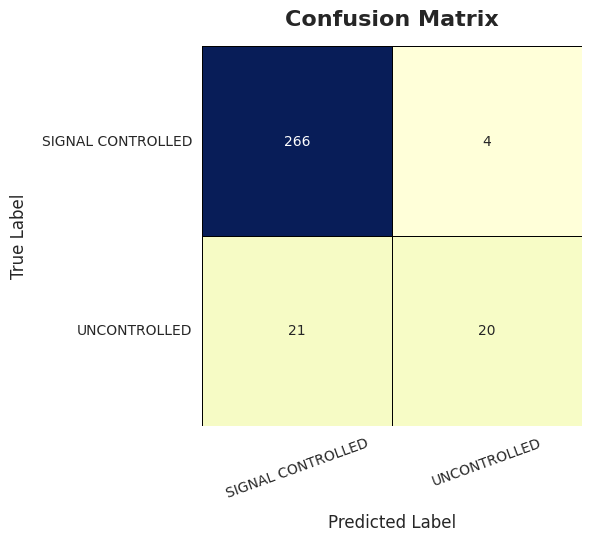

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot
plt.figure(figsize=(6, 6))
sns.set_style("white")

ax = sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="YlGnBu",
    cbar=False,
    linewidths=0.7,
    linecolor='black',
    xticklabels=le_target.classes_,
    yticklabels=le_target.classes_,
    square=True
)

# Rotate ticks
plt.xticks(rotation=20)
plt.yticks(rotation=0)

# Labels and title
plt.xlabel("Predicted Label", fontsize=12, labelpad=10)
plt.ylabel("True Label", fontsize=12, labelpad=10)
plt.title("Confusion Matrix", fontsize=16, fontweight="bold", pad=15)

plt.tight_layout()
plt.show()



#Neural Network

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix

# === 1. Clean dataset ===
df["ITEM_TYPE_NAME"] = df["ITEM_TYPE_NAME"].replace("?", np.nan)
df["CROSSING_TYPE_NAME"] = df["CROSSING_TYPE_NAME"].replace("?", np.nan)
df = df.dropna(subset=["CROSSING_TYPE_NAME"])

# === 2. Features & target ===
X = df.drop(columns=["CROSSING_TYPE_NAME"])
y = df["CROSSING_TYPE_NAME"]

# Encode target
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Identify categorical & numeric columns
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numeric_cols = X.select_dtypes(exclude=["object"]).columns.tolist()

# Preprocess features
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", StandardScaler(), numeric_cols)
    ]
)

X_processed = preprocessor.fit_transform(X)

# Apply SMOTE for balancing
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_processed, y_encoded)
y_res_categorical = to_categorical(y_res)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res_categorical, test_size=0.2, random_state=42, stratify=y_res
)

# === 3. Build neural network ===
input_dim = X_train.shape[1]

model = Sequential([
    Dense(128, activation="relu", input_dim=input_dim),
    Dropout(0.3),
    Dense(64, activation="relu"),
    Dropout(0.2),
    Dense(y_train.shape[1], activation="softmax")  # Output layer
])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# === 4. Train model ===
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2)

# === 5. Predict & evaluate ===
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

print("Classification Report:")
print(classification_report(y_test_labels, y_pred, target_names=le.classes_))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_labels, y_pred))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5792 - loss: 0.6478 - val_accuracy: 0.7087 - val_loss: 0.5633
Epoch 2/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7721 - loss: 0.4829 - val_accuracy: 0.8830 - val_loss: 0.3318
Epoch 3/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9307 - loss: 0.2300 - val_accuracy: 0.9335 - val_loss: 0.1856
Epoch 4/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9477 - loss: 0.1514 - val_accuracy: 0.9472 - val_loss: 0.1546
Epoch 5/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9583 - loss: 0.0998 - val_accuracy: 0.9450 - val_loss: 0.1610
Epoch 6/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9700 - loss: 0.0871 - val_accuracy: 0.9495 - val_loss: 0.1450
Epoch 7/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9629 - loss: 0.0978 - val_accuracy: 0.9427 - val_loss: 0.1481
Epoch 8/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9597 - loss: 0.0971 - val_accuracy: 0.9541 - val_l

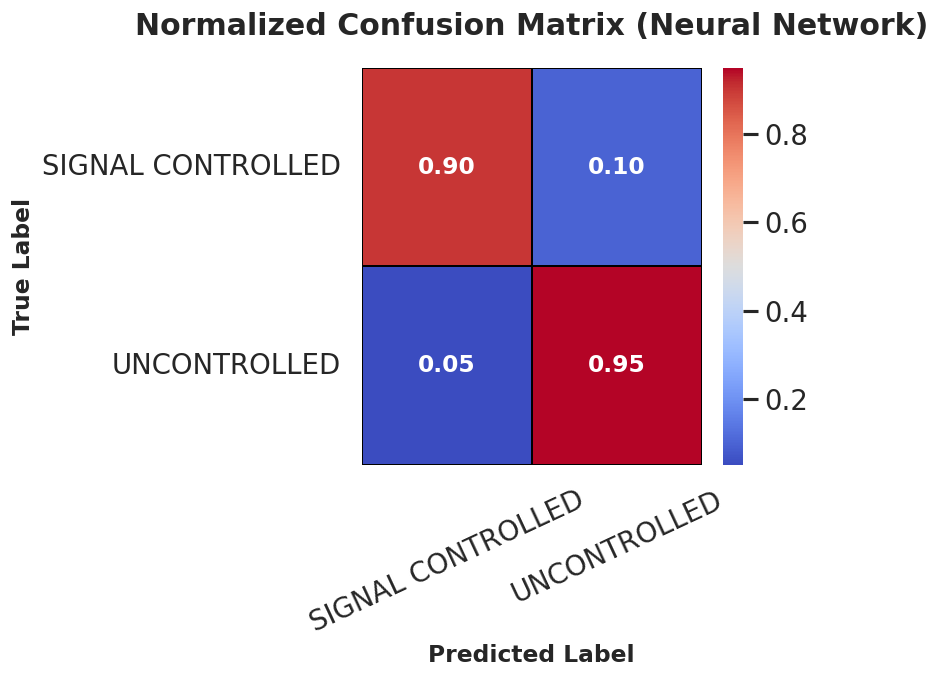

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# === 1. Prepare true and predicted labels ===
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred_prob, axis=1)

# === 2. Compute confusion matrix ===
cm = confusion_matrix(y_true, y_pred)

# === 3. Normalize by row totals ===
cm_normalized = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

# === 4. Define class labels ===
class_labels = ["SIGNAL CONTROLLED", "UNCONTROLLED"]

# === 5. Create a higher-quality, modern-looking heatmap ===
plt.figure(figsize=(7, 6), dpi=120)  # Higher resolution
sns.set_style("whitegrid")
sns.set_context("talk")               # Bigger fonts for readability

ax = sns.heatmap(
    cm_normalized,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",                   # Modern diverging color palette
    xticklabels=class_labels,
    yticklabels=class_labels,
    cbar=True,                         # Show color bar
    linewidths=1.0,
    linecolor='black',
    annot_kws={"size": 14, "weight": "bold"}
)

# === 6. Customize labels and title ===
plt.title("Normalized Confusion Matrix (Neural Network)", fontsize=18, fontweight="bold", pad=20)
plt.xlabel("Predicted Label", fontsize=14, fontweight="bold")
plt.ylabel("True Label", fontsize=14, fontweight="bold")
plt.xticks(rotation=25)
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()


In [25]:
import pandas as pd
import numpy as np
import folium
from pyproj import Transformer
import branca

# =======================
# 1. Load new dataset to visualize predictions
# =======================
df_aug = pd.read_csv("/content/drive/MyDrive/Pedestrian_Crossing.csv")  # Replace with your file

# Keep same preprocessing as training
X_aug = df_aug.drop(columns=["CROSSING_TYPE_NAME"])
X_aug_processed = preprocessor.transform(X_aug)  # ColumnTransformer from your model code

# =======================
# 2. Predict with neural network
# =======================
y_pred_prob_aug = model.predict(X_aug_processed)
y_pred_classes_aug = np.argmax(y_pred_prob_aug, axis=1)

# Convert numeric labels back to original class names
df_aug["PRED_CROSSING_TYPE"] = le.inverse_transform(y_pred_classes_aug)

# =======================
# 3. Convert Irish Grid to WGS84 (lat/lon)
# =======================
transformer = Transformer.from_crs("EPSG:29902", "EPSG:4326", always_xy=True)
df_aug["LON"], df_aug["LAT"] = transformer.transform(df_aug["EASTING"].values, df_aug["NORTHING"].values)

# =======================
# 4. Assign colors for predicted crossing types
# =======================
unique_types = df_aug["PRED_CROSSING_TYPE"].unique()
color_palette = ["blue", "orange", "purple", "pink", "brown", "cadetblue"]
color_map = {cross_type: color_palette[i % len(color_palette)] for i, cross_type in enumerate(unique_types)}

# =======================
# 5. Create map centered over Northern Ireland
# =======================
m = folium.Map(location=[54.6, -6.7], zoom_start=8)

# =======================
# 6. Add markers
# =======================
for _, row in df_aug.iterrows():
    is_correct = row["CROSSING_TYPE_NAME"] == row["PRED_CROSSING_TYPE"]
    marker_color = "green" if not is_correct else color_map.get(row["PRED_CROSSING_TYPE"], "gray")

    folium.CircleMarker(
        location=[row["LAT"], row["LON"]],
        radius=4 if not is_correct else 3,
        popup=f"{row['CROSSING_TYPE_NAME']} → {row['PRED_CROSSING_TYPE']}",
        color=marker_color,
        fill=True,
        fill_color=marker_color,
        fill_opacity=0.7
    ).add_to(m)

# =======================
# 7. Add legend
# =======================
legend_html = """
<div style="position: fixed;
     bottom: 50px; left: 50px; width: 220px; height: auto;
     background-color: white; z-index:9999; font-size:14px;
     border:2px solid grey; border-radius:5px; padding: 10px;">
     <b>Predicted Crossing Types</b><br>
"""
for cross_type, color in color_map.items():
    legend_html += f'<i style="background:{color};width:12px;height:12px;display:inline-block;margin-right:5px;"></i>{cross_type}<br>'
legend_html += '<i style="background:green;width:12px;height:12px;display:inline-block;margin-right:5px;"></i>Misclassified</div>'

m.get_root().html.add_child(folium.Element(legend_html))

# =======================
# 8. Save & display map
# =======================
m.save("/content/drive/MyDrive/predicted_crossings_ni.html")
m


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
